In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
import os

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arpit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\arpit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arpit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arpit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# notebooks/01_EDA.ipynb


# Load dataset
df = pd.read_csv('../fake_job_postings.csv')

In [3]:
print("\nSample of data:")
df.head()


Sample of data:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
# Show basic info
print(f"Dataset loaded with shape: {df.shape}")
print(df.info())
# Basic descriptions
#print(df.describe(include='object'))

Dataset loaded with shape: (17880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry      

In [5]:
# Check missing values
missing_values = df.isnull().sum()
missing_percentage = missing_values / len(df) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
}).sort_values('Percentage', ascending=False)

print("\nMissing Values Analysis:")
print(missing_df[missing_df['Missing Values'] > 0])


Missing Values Analysis:
                     Missing Values  Percentage
salary_range                  15012   83.959732
department                    11547   64.580537
required_education             8105   45.329978
benefits                       7212   40.335570
required_experience            7050   39.429530
function                       6455   36.101790
industry                       4903   27.421700
employment_type                3471   19.412752
company_profile                3308   18.501119
requirements                   2696   15.078300
location                        346    1.935123
description                       1    0.005593


In [6]:
#removing the columns which are not useful for the analysis
# We have droped salary range because 70% approx null value
# also job_id and other irrelvent columns because they does not have any logical meaning
df.drop(['job_id', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions'],axis=1,inplace = True)

In [7]:
print(df.shape)
df.head()

(17880, 13)


,title,location,department,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [8]:
# Drop 'department' due to high missing %
df.drop(columns=['department'], inplace=True)


In [9]:
# Fill text columns with empty strings
text_columns = ['company_profile', 'description', 'requirements', 'benefits','location']
for col in text_columns:
    df[col] = df[col].fillna("")

# Fill categorical columns with "Unknown"
categorical_columns = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
for col in categorical_columns:
    df[col] = df[col].fillna("Unknown")


In [10]:
df.isnull().sum()

title                  0
location               0
company_profile        0
description            0
requirements           0
benefits               0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

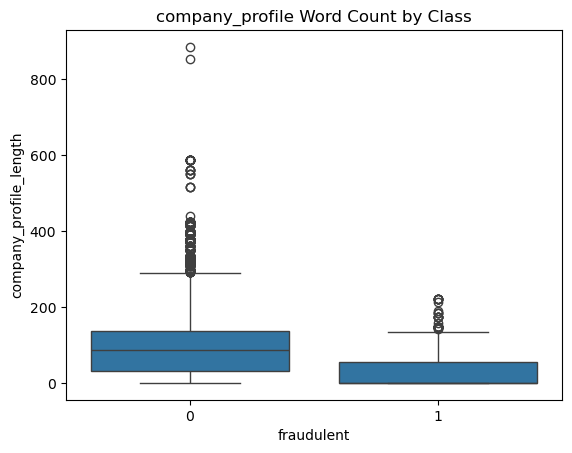

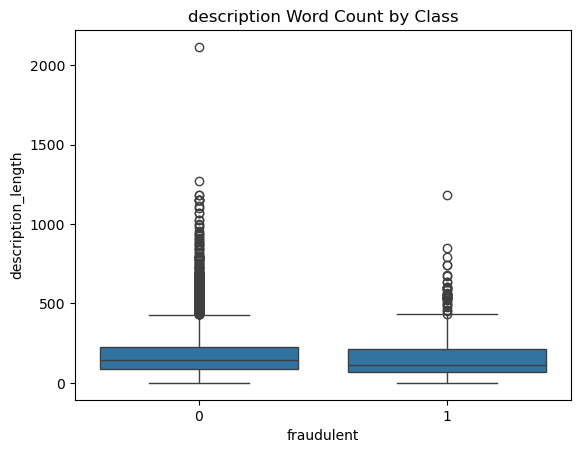

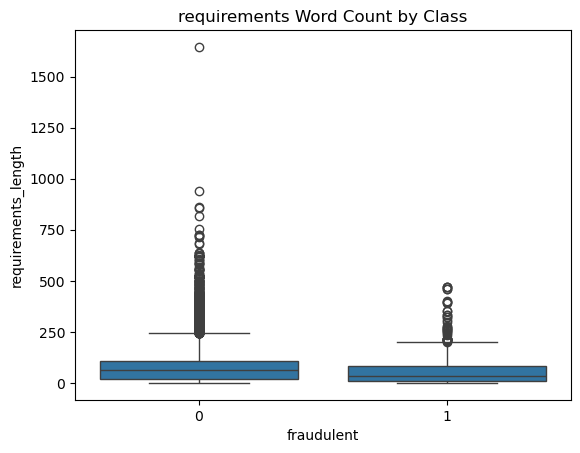

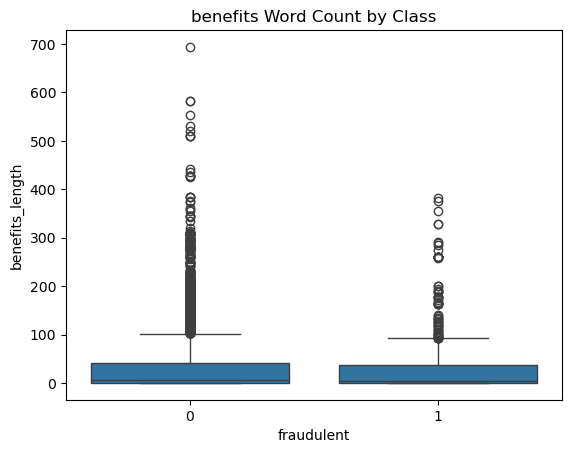

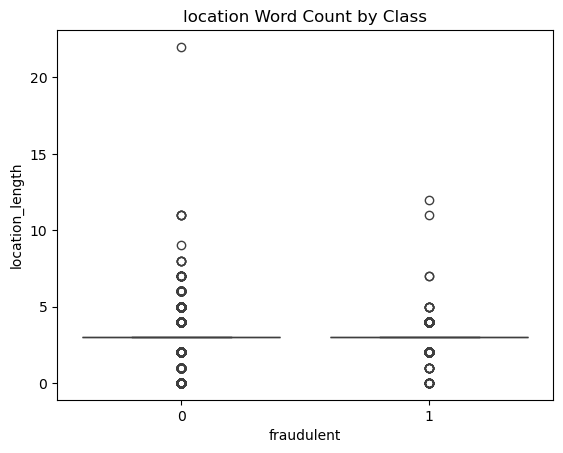

In [11]:
for col in text_columns:
    df[f'{col}_length'] = df[col].apply(lambda x: len(x.split()))

    sns.boxplot(x='fraudulent', y=f'{col}_length', data=df)
    plt.title(f"{col} Word Count by Class")
    plt.show()


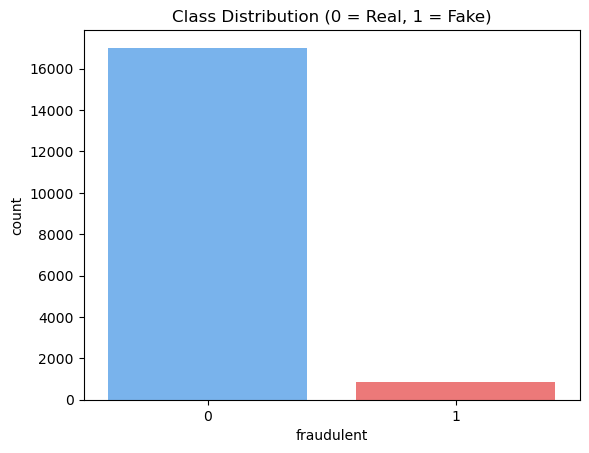

In [36]:
# Target distribution
sns.countplot(data=df, x='fraudulent',palette=['#66b3ff', '#ff6666'])
plt.title("Class Distribution (0 = Real, 1 = Fake)")
plt.show()


Class Distribution:
Fraudulent jobs: 866 (4.84%)
Legitimate jobs: 17014 (95.16%)


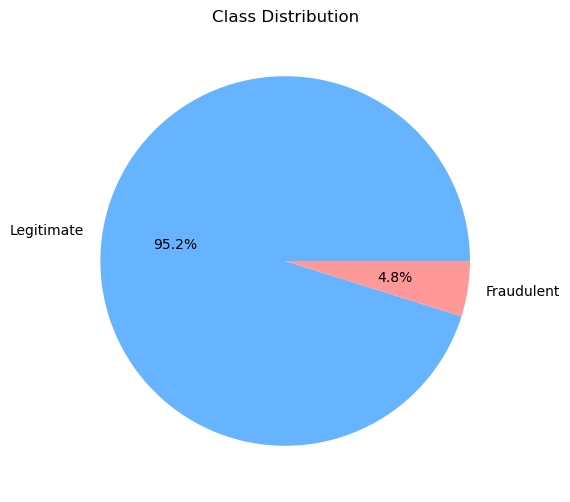

In [14]:
# Check class distribution
fraud_count = df['fraudulent'].sum()
legitimate_count = len(df) - fraud_count
print(f"Class Distribution:")
print(f"Fraudulent jobs: {fraud_count} ({fraud_count/len(df)*100:.2f}%)")
print(f"Legitimate jobs: {legitimate_count} ({legitimate_count/len(df)*100:.2f}%)")

# Visualize class distribution
plt.figure(figsize=(8, 6))
plt.pie([legitimate_count, fraud_count], 
        labels=['Legitimate', 'Fraudulent'],
        autopct='%1.1f%%', 
        colors=['#66b3ff', '#ff9999'])
plt.title('Class Distribution')
plt.show()




In [19]:

# we will try to see which country is posting most of the jobs
# Visualize job postings by countries
# we will use the location column for visualizing this data
# In location data is of type (country_name,state,city)
# we neeed to know the country wise data

def split(location):
    l = location.split(',')
    return l[0]

df['country'] = df.location.apply(split)
df['country']

0        US
1        NZ
2        US
3        US
4        US
         ..
17875    CA
17876    US
17877    US
17878    NG
17879    NZ
Name: country, Length: 17880, dtype: object

In [25]:

# this will give unique country values
df['country'].nunique()

91

Text(0.5, 0, 'Countries')

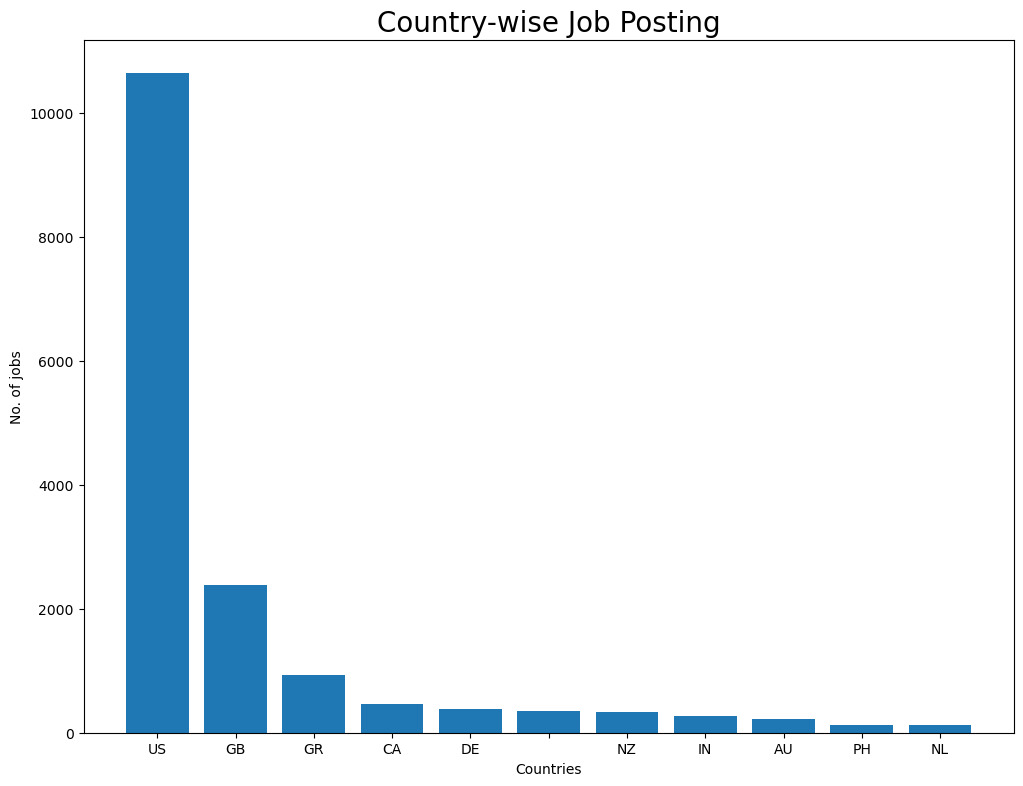

In [34]:
# creating a dictionary(key-value pair) with top 10 country
country = dict(df.country.value_counts()[:11])
#del country[' '] #deleting country with space values
plt.figure(figsize=(12,9))
plt.title('Country-wise Job Posting', size=20)
plt.bar(country.keys(), country.values()) #(xaxis,yaxis)
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)

In [27]:

country.keys()

dict_keys(['US', 'GB', 'GR', 'CA', 'DE', '', 'NZ', 'IN', 'AU', 'PH', 'NL'])

### Feature Engineering and Pre Processing

In [14]:
# TEXT CLEANING & FEATURE EXTRACTION
# ----------------------------

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Lowercase, tokenize, remove stopwords and lemmatize."""
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        cleaned_tokens = [
            lemmatizer.lemmatize(token)
            for token in tokens
            if token.isalpha() and token not in stop_words
        ]
        return ' '.join(cleaned_tokens)
    else:
        return ''

# Only apply to text columns that exist
text_columns = ['description', 'requirements', 'benefits', 'company_profile']
text_columns = [col for col in text_columns if col in df.columns]

for col in text_columns:
    print(f"Processing: {col}")
    df[f'{col}_cleaned'] = df[col].fillna('').apply(preprocess_text)
    df[f'{col}_word_count'] = df[f'{col}_cleaned'].apply(lambda x: len(x.split()))


# ----------------------------
# MISSING VALUE FLAGS
# ----------------------------
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[f'{col}_is_missing'] = df[col].isnull().astype(int)

# ----------------------------
# SUSPICIOUS TITLE KEYWORD COUNT
# ----------------------------
suspicious_title_words = ['urgent', 'immediate', 'work from home', 'make money', 'no experience', 'easy']

def count_suspicious_words(title):
    if not isinstance(title, str):
        return 0
    title_lower = title.lower()
    return sum(1 for word in suspicious_title_words if word in title_lower)

df['title_suspicious_count'] = df['title'].apply(count_suspicious_words)

# ----------------------------
# DROP UNUSED COLUMNS FOR MODELING
# ----------------------------
columns_to_drop = text_columns  # Already processed versions exist (cleaned)
modeling_df = df.drop(columns=columns_to_drop, errors='ignore')

print(f"\n✅ Final modeling_df prepared with shape: {modeling_df.shape}")

Processing: description
Processing: requirements
Processing: benefits
Processing: company_profile

✅ Final modeling_df prepared with shape: (17880, 22)


In [30]:
modeling_df.columns

Index(['title', 'location', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent',
       'company_profile_length', 'description_length', 'requirements_length',
       'benefits_length', 'location_length', 'description_cleaned',
       'description_word_count', 'requirements_cleaned',
       'requirements_word_count', 'benefits_cleaned', 'benefits_word_count',
       'company_profile_cleaned', 'company_profile_word_count',
       'title_suspicious_count'],
      dtype='object')

In [31]:
modeling_df.shape

(17880, 22)

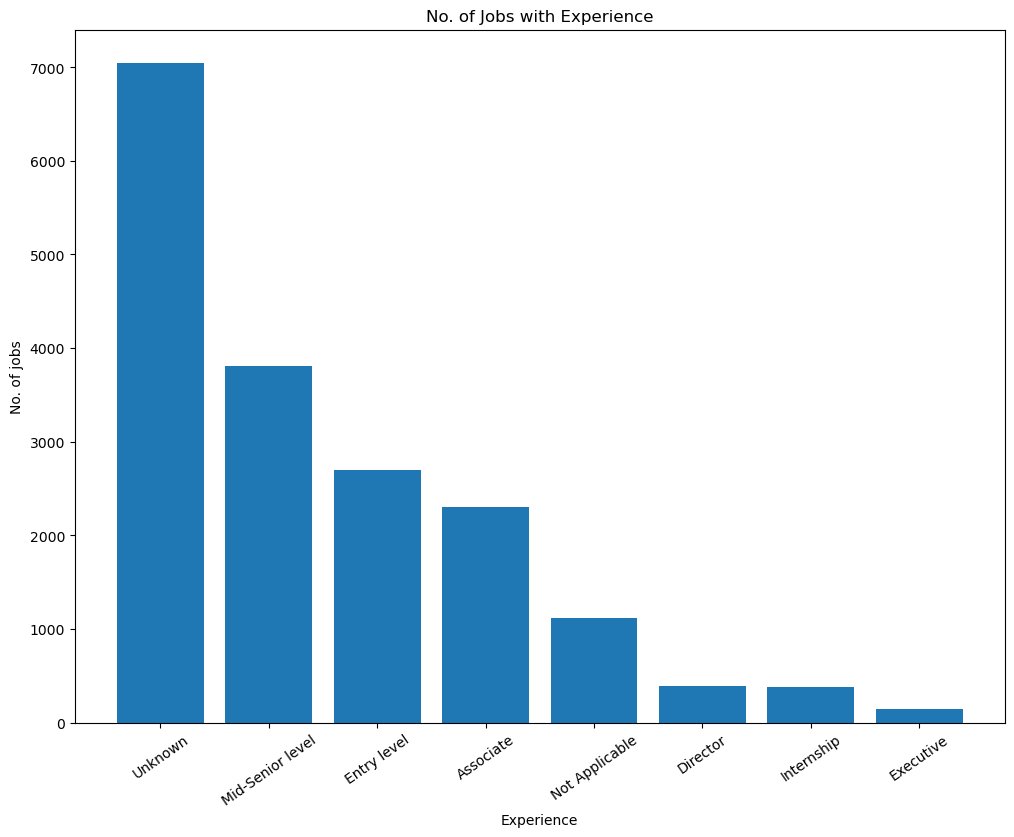

In [33]:

# visualizing jobs based on experience
experience = dict(modeling_df.required_experience.value_counts())

plt.figure(figsize=(12,9))
plt.bar(experience.keys(), experience.values())
plt.title('No. of Jobs with Experience')
plt.xlabel('Experience', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()

In [17]:

# Ensure directory exists
os.makedirs("../models", exist_ok=True)

# Save to CSV
modeling_df.to_csv("../models/final_balanced_train.csv", index=False)

print("✅ Saved balanced, processed training data to: models/final_balanced_train.csv")





✅ Saved balanced, processed training data to: models/final_balanced_train.csv
